# Lennard Jones

The Lennard-Jones system is the simplest example of a MD simulation.

## Initialize

Import the hoomd python package and the md component to execute MD simulations.

In [97]:
from math import *
import hoomd
import hoomd.md
import hoomd.deprecated
import numpy 
from matplotlib import pyplot as plt 
import gsd 
import gsd.hoomd
import gsd.pygsd

Initialize the execution context to control where HOOMD will execute the simulation. When no command line options are provided, HOOMD will auto-select a GPU if it exists, or run on the CPU.

In [98]:
hoomd.context.initialize("");

Initialize a $n$ by $n$ by $n$ simple cubic lattice of particles. The lattice initializer by default creates all particles named type "A", and with 0 velocity.

In [99]:
hoomd.init.create_lattice(unitcell=hoomd.lattice.sc(a=2.0), n=5);

notice(2): Group "all" created containing 125 particles


**Parameters:**

In [100]:
change_seed = 650786
"""Lennard-Jones style Normalized parameters"""
kB_r            = 1 
mass_r          = 1 
LJ_sigma_r      = 1 
LJ_epsilon_r    = 1 
r_cut_LJ_r      = 2.5
time_step_r     = 0.005
drag_coeff_r    = 1
T_r             = 0.2                            
sim_time_r      = 100e3
log_period_r    = 1e2

## Define potential energy

$ V(r) = 4 \varepsilon \left[ \left( \frac{\sigma}{r} \right)^{12} - \left( \frac{\sigma}{r} \right)^{6} \right] $

In the Lennard-Jones system, pairs of particles closer than $r_\mathrm{cut}$ interact with this potential energy.

Choose the neighbor list acceleration structure to find neighboring particles efficiently. In systems with only one cutoff length, the cell method performs best.

In [101]:
#nl = hoomd.md.nlist.cell();

Define the functional form of the pair interaction and evaluate using the given neighbor list acceleration structure.

In [102]:
#lj = hoomd.md.pair.lj(r_cut=r_cut_LJ_r, nlist=nl)

Specify pair potential parameters for every pair of types in the simulation.

In [103]:
#lj.pair_coeff.set('A', 'A', epsilon=LJ_epsilon_r, sigma=LJ_sigma_r);

## Select integrator

The integrator defines the equations of motion that govern the system of particles, given the current configuration of the particles and the net force from all potentials. The standard integration mode in HOOMD allows different integrators to apply to different groups of particles with the same step size $dt$.

In [104]:
hoomd.md.integrate.mode_standard(dt=time_step_r);

Apply the Langevin equations of motion to all particles. $kT$ defines the temperature of the system in energy units and *seed* defines the seed for the random number generator.

In [105]:
all = hoomd.group.all();
hoomd.md.integrate.langevin(group=all, kT=kB_r*T_r, seed=change_seed);

notice(2): integrate.langevin/bd is using specified gamma values


## Write output

Periodically log the potential energy of the system to a text file.

In [106]:
hoomd.analyze.log(filename="log-output.log",
                  quantities=['potential_energy', 'temperature'],
                  period=log_period_r,
                  overwrite=True);

Periodically write the particle configurations to a gsd file.

In [107]:
hoomd.dump.gsd("trajectory.gsd", period=2e3, group=all, overwrite=True);

In [108]:
hoomd.deprecated.analyze.msd(filename='msd.log',
                  groups=[all],
                  period=log_period_r,
                  overwrite=True)

## Run the simulation

Take 10,000 steps forward in time.

In [109]:
hoomd.run(sim_time_r);

** starting run **
Time 00:00:01 | Step 100000 / 100000 | TPS 69792.3 | ETA 00:00:00
Average TPS: 69641.1
---------
** run complete **


## Examine the output

Use matplotlib to plot the potential energy vs time step.

In [110]:
import numpy 
from matplotlib import pyplot
%matplotlib inline
data = numpy.genfromtxt(fname='log-output.log', skip_header=True);

Obtain msd, plot msd vs. time, calculate D_theory and D_sim

LinregressResult(slope=1.2370809890414431, intercept=-0.20904981318392402, rvalue=0.9974784143361957, pvalue=0.0, stderr=0.0031177649954395293)
D_sim: 0.20127541883333333
D_sim_2: 0.20618016484024052
D_theory: 0.2


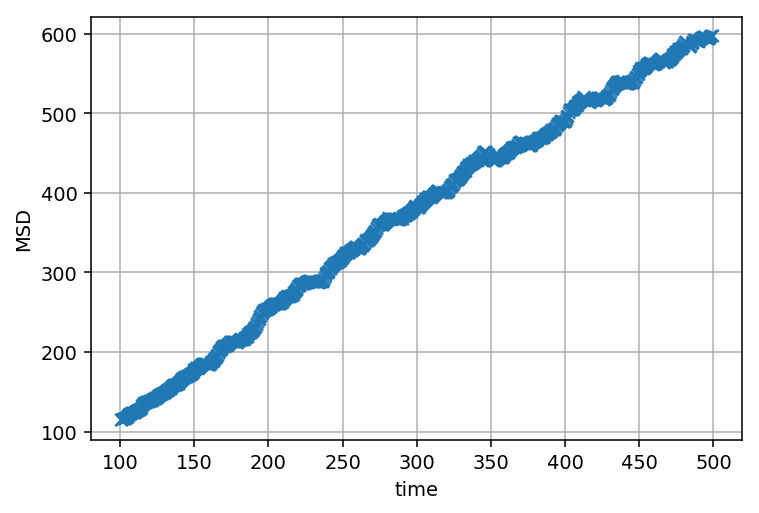

In [116]:
msd = numpy.genfromtxt(fname='msd.log', skip_header=True);
x = msd[201:,0]*time_step_r
y = msd[201:,1]

from scipy.stats import linregress
print(linregress(x,y)) #x and y are arrays or lists.   
slope, intercept, r_value, p_value, std_err = linregress(x, y)

D_sim = (msd[-1,1] - msd[201,1]) / ((sim_time_r-20e3)*time_step_r) / 6 
D_sim_2 = slope / 6
D_theory = kB_r * T_r / drag_coeff_r
print("D_sim: "+str(D_sim))
print("D_sim_2: "+str(D_sim_2))
print("D_theory: "+str(D_theory))
           
plt.figure(figsize=None, dpi=140);
plt.plot(x, y, 'x');
plt.xlabel('time');
plt.ylabel('MSD');
plt.grid(True)

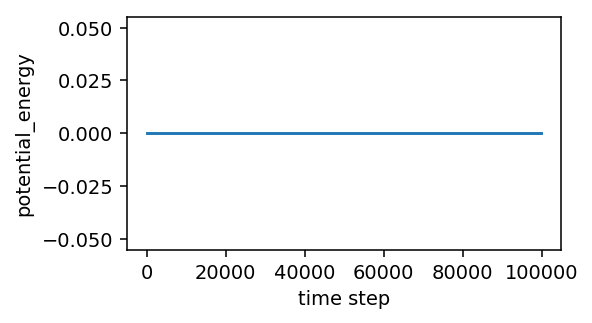

In [113]:
pyplot.figure(figsize=(4,2.2), dpi=140);
pyplot.plot(data[:,0], data[:,1]);
pyplot.xlabel('time step');
pyplot.ylabel('potential_energy');

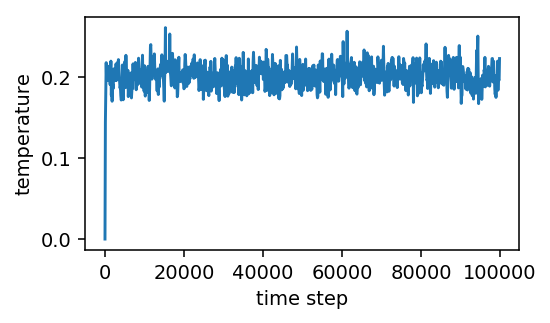

In [114]:
pyplot.figure(figsize=(4,2.2), dpi=140);
pyplot.plot(data[:,0], data[:,2]);
pyplot.xlabel('time step');
pyplot.ylabel('temperature');

Examine how the system configuration evolves over time. [ex_render](ex_render.py) is a helper script that builds animated gifs from trajectory files and system snapshots. It is part of the [hoomd-examples](https://bitbucket.org/glotzer/hoomd-examples) repository and designed only to render these examples.

In [115]:
#import ex_render
#ex_render.display_movie(ex_render.render_sphere_frame, 'trajectory.gsd');